In [1]:
cd ../analysis/

/srv/data/home/jlee782/segmentation/analysis


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2
from withClustAnalysis import *
from PixelEM import * 

Populating the interactive namespace from numpy and matplotlib


/home/jlee782/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
# compile MV PRJ result from each cluster to CSV
MV_df = compile_cluster_MV_prj_into_csv()
# Pick best clusters for each object sample based on MV
best_clust_df = best_worker_picking()
# compile all algo and MV PRJs into one big table
df = compile_all_algo_PRJs()
# compile the best threshold PRJs into one big table with algo as a column
df_best_thresh = compile_best_thresh_all_algo_PRJs()
# Extracting important clusters only
best_clust_best_thresh_df = filter_best_clust(df_best_thresh,best_clust_df)
best_clust_no_thresh_df  = filter_best_clust(df,best_clust_df)

In [41]:
# #exclude small area objects
# small_area=[11,15]

# best_clust_best_thresh_df= best_clust_best_thresh_df[~best_clust_best_thresh_df.objid.isin(small_area)]
# best_clust_no_thresh_df= best_clust_no_thresh_df[~best_clust_no_thresh_df.objid.isin(small_area)]

### Performance as it varies with number of workers

In [42]:
# MV should be the same, whether best thresh picked or not (since MV indept of thresh)
# assert best_clust_best_thresh_df[best_clust_best_thresh_df["algo"]=="MV"]["j"].mean() == best_clust_no_thresh_df["J [MV]"].mean()

In [43]:
#best_thres_best_clust_df[["objid","J [GTLSA]"]]#.objid.unique()#.groupby("num_workers")["J [MV]"]

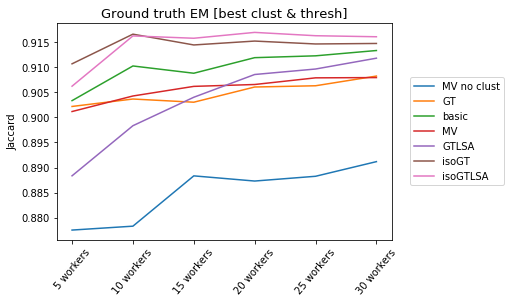

In [44]:
Nworker_performance = best_clust_best_thresh_df.groupby(['algo','num_workers'],as_index=False)[['j']].mean()
metric_J = [metric for metric in metric_keys if 'J' in metric ]
# original "whole" MV PRJ for every object table --> MV_noClust : MV with no clustering

MV_withClust = np.array(Nworker_performance[Nworker_performance["algo"]=='MV']["j"])
MV = pd.read_csv("pixel_em/MV_PRJ_table.csv") 
MV_noClust = np.array(MV.groupby("num_workers").mean()["MV_jaccard"])
plt.plot(MV_noClust,label="MV no clust")
for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Greedy Picking [best clust]",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM [best clust & thresh]",fontsize=13)

In [7]:
print "isoGTLSA_best_clust_thresh=",list(Nworker_performance[Nworker_performance["algo"]=='isoGTLSA']["j"])
print "isoGT_best_clust_thresh=",list(Nworker_performance[Nworker_performance["algo"]=='isoGT']["j"])

isoGTLSA_best_clust_thresh= [0.90622168028021999, 0.91624670990657464, 0.91578356001410866, 0.91695038353900216, 0.91628755477867763, 0.91608113531438529]
isoGT_best_clust_thresh= [0.91068403845485024, 0.91659798451209973, 0.91444606678799101, 0.91522098077817648, 0.91464263911409394, 0.91474348352863577]


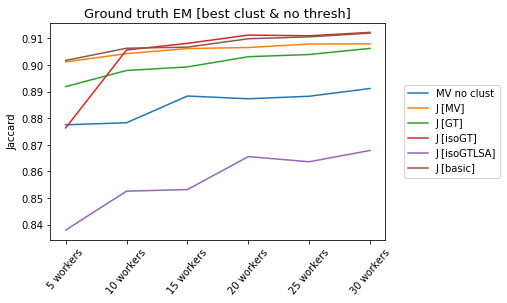

In [8]:
Nworker_performance = best_clust_no_thresh_df.groupby("num_workers").mean()
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
# original "whole" MV PRJ for every object table --> MV_noClust : MV with no clustering
MV = pd.read_csv("pixel_em/MV_PRJ_table.csv") 
MV_noClust = np.array(MV.groupby("num_workers").mean()["MV_jaccard"])
plt.plot(MV_noClust,label="MV no clust")

for algo in metric_J:
    if '[GTLSA]' not in algo:#exclude *GTLSA for now
        plt.plot(np.array(Nworker_performance[algo]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM [best clust & no thresh]",fontsize=13)

In [9]:
print "isoGTLSA_best_clust_no_thresh=",list(Nworker_performance['J [isoGTLSA]'])
print "isoGT_best_clust_no_thresh=",list(Nworker_performance['J [isoGT]'])

isoGTLSA_best_clust_no_thresh= [0.83798513327754942, 0.85260123233056029, 0.85319940681821504, 0.86557959249206329, 0.86364630057192693, 0.86789370397528687]
isoGT_best_clust_no_thresh= [0.87637800778911845, 0.90563932604972763, 0.9081308416431505, 0.91123537087537898, 0.91097207169619554, 0.91224160583644398]


# Greedy Algo Results

In [10]:
greedy_df = compile_withClust_greedy_algos_to_csv()
# best_clust = greedy_df.loc[greedy_df.groupby(['sample','objid','cluster_id'])["j"].idxmax()]

In [11]:
greedy_df = filter_best_clust(greedy_df,best_clust_df)

In [12]:
assert int(greedy_df.groupby(["num_workers","objid","sample_num","algo"]).count()["j"].unique())==1

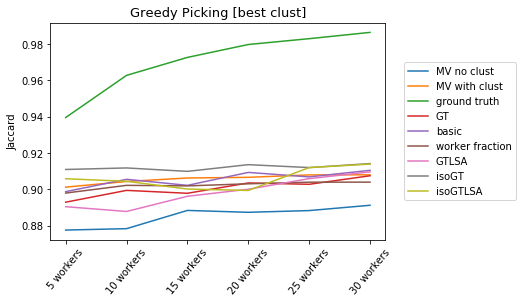

In [13]:
Nworker_performance = greedy_df.groupby(['algo','num_workers'],as_index=False)[['j']].mean()
plt.plot(MV_noClust,label="MV no clust")
plt.plot(MV_withClust,label="MV with clust")
for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Greedy Picking [best clust]",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])


In [14]:
print "greedy_ground_truth=",list(Nworker_performance[Nworker_performance["algo"]=="ground truth"]['j'])
print "greedy_best_clust_isoGT=",list(Nworker_performance[Nworker_performance["algo"]=="isoGT"]['j'])
print "greedy_best_clust_worker_frac=",list(Nworker_performance[Nworker_performance["algo"]=="worker fraction"]['j'])

greedy_ground_truth= [0.93945579463386852, 0.96266602709650861, 0.97255700868926886, 0.97965396048192555, 0.98286834173734094, 0.9863217494865455]
greedy_best_clust_isoGT= [0.91087815642516201, 0.91171807743536248, 0.90983655930196838, 0.91352433722823823, 0.91192492479916643, 0.9141222300016667]
greedy_best_clust_worker_frac= [0.89789288455882865, 0.9021416858188871, 0.90184085235351585, 0.90299242828784521, 0.90387937369357174, 0.90390956205647621]


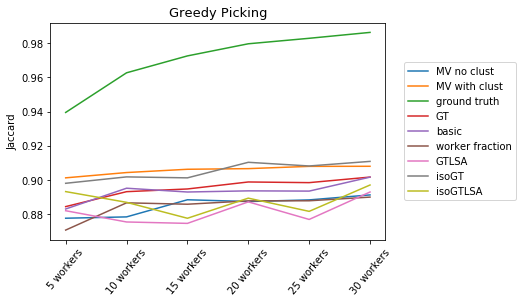

In [15]:
noClust_greedy_df = compile_noClust_greedy_algos_to_csv()
Nworker_performance = noClust_greedy_df.groupby(['algo','num_workers'],as_index=False)[['j']].mean()
plt.plot(MV_noClust,label="MV no clust")
plt.plot(MV_withClust,label="MV with clust")

for algo in list(set(Nworker_performance["algo"])):
    plt.plot(np.array(Nworker_performance[Nworker_performance["algo"]==algo][['j']]),label=algo)
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
plt.title("Greedy Picking",fontsize=13)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])


In [16]:
print "greedy_no_clust_isoGT=",list(Nworker_performance[Nworker_performance["algo"]=="isoGT"]['j'])
print "greedy_no_clust_worker_frac=",list(Nworker_performance[Nworker_performance["algo"]=="worker fraction"]['j'])

greedy_no_clust_isoGT= [0.89798084966980929, 0.90172692332783833, 0.90115935241699163, 0.91026799603210795, 0.90811380044456835, 0.91080227077649989]
greedy_no_clust_worker_frac= [0.87059208586784431, 0.88653805811473196, 0.88572357142652258, 0.88768491119243764, 0.88774048826785179, 0.88989101610129528]


### Compare between best thresh, best cluster thresh, no filtering

In [17]:
isoGT= [0.86180714318405227, 0.8988109346737535, 0.90404005468171478, 0.90954740011618374, 0.90776463234071514, 0.91052706488955748]
isoGT_best_thresh= [0.88030482691468614, 0.90370402275291195, 0.90762227879598867, 0.91135894959171038, 0.90901508399830366, 0.91165606774023689]
isoGT_best_clust_thresh= [0.91068403845485024, 0.91659798451209973, 0.91444606678799101, 0.91522098077817648, 0.91464263911409394, 0.91474348352863577]
isoGT_best_clust_no_thresh= [0.87637800778911845, 0.90563932604972763, 0.9081308416431505, 0.91123537087537898, 0.91097207169619554, 0.91224160583644398]

isoGTLSA= [0.86001952128075243, 0.8852958258350111, 0.88859038520376588, 0.89840505843053553, 0.89202225166859883, 0.90219252902030678]
isoGTLSA_best_thresh= [0.87519051694562056, 0.8998780616894021, 0.90556915704845498, 0.9106581626726421, 0.90980669965364624, 0.911292941153929]
isoGTLSA_best_clust_thresh= [0.90622168028021999, 0.91624670990657464, 0.91578356001410866, 0.91695038353900216, 0.91628755477867763, 0.91608113531438529]
isoGTLSA_best_clust_no_thresh= [0.83798513327754942, 0.85260123233056029, 0.85319940681821504, 0.86557959249206329, 0.86364630057192693, 0.86789370397528687]
#################################
greedy_ground_truth= [0.93945579463386852, 0.96266602709650861, 0.97255700868926886, 0.97965396048192555, 0.98286834173734094, 0.9863217494865455]
greedy_best_clust_isoGT= [0.91087815642516201, 0.91171807743536248, 0.90983655930196838, 0.91352433722823823, 0.91192492479916643, 0.9141222300016667]
greedy_best_clust_worker_frac= [0.89789288455882865, 0.9021416858188871, 0.90184085235351585, 0.90299242828784521, 0.90387937369357174, 0.90390956205647621]

greedy_no_clust_isoGT= [0.89798084966980929, 0.90172692332783833, 0.90115935241699163, 0.91026799603210795, 0.90811380044456835, 0.91080227077649989]
greedy_no_clust_worker_frac= [0.87059208586784431, 0.88653805811473196, 0.88572357142652258, 0.88768491119243764, 0.88774048826785179, 0.88989101610129528]

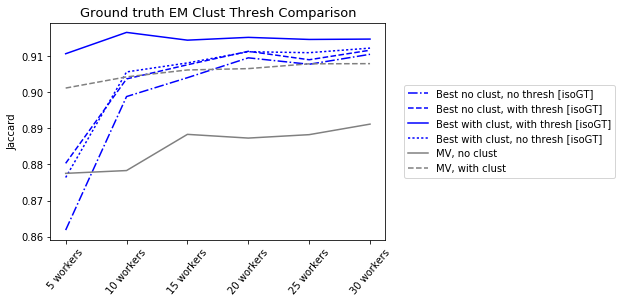

In [18]:
algoDict=[{"val":isoGT,"name":'Best no clust, no thresh [isoGT]','color':"blue",'linestyle':"-."},
    {"val":isoGT_best_thresh,"name":'Best no clust, with thresh [isoGT]','color':"blue",'linestyle':"--"},
    {"val":isoGT_best_clust_thresh,"name":'Best with clust, with thresh [isoGT]','color':"blue",'linestyle':"-"},
    {"val":isoGT_best_clust_no_thresh,"name":'Best with clust, no thresh [isoGT]','color':"blue",'linestyle':":"},

    {"val":MV_noClust,"name":'MV, no clust','color':"gray",'linestyle':"-"},
    {"val":MV_withClust,"name":'MV, with clust','color':"gray",'linestyle':"--"},
]

metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in algoDict:
    plt.plot(algo["val"],label=algo["name"],color=algo["color"],linestyle=algo["linestyle"])
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM Clust Thresh Comparison",fontsize=13)

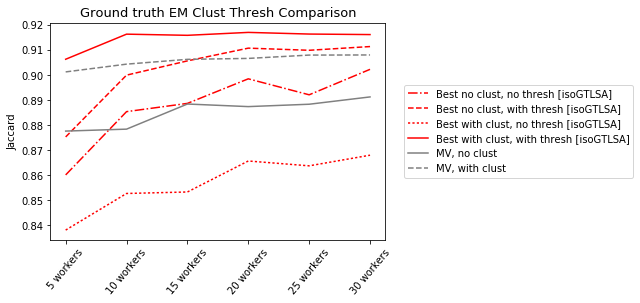

In [19]:
algoDict=[
    {"val":isoGTLSA,"name":'Best no clust, no thresh [isoGTLSA]','color':"red",'linestyle':"-."},
    {"val":isoGTLSA_best_thresh,"name":'Best no clust, with thresh [isoGTLSA]','color':"red",'linestyle':"--"},
    {"val":isoGTLSA_best_clust_no_thresh,"name":'Best with clust, no thresh [isoGTLSA]','color':"red",'linestyle':":"},
    {"val":isoGTLSA_best_clust_thresh,"name":'Best with clust, with thresh [isoGTLSA]','color':"red",'linestyle':"-"},
    
    {"val":MV_noClust,"name":'MV, no clust','color':"gray",'linestyle':"-"},
    {"val":MV_withClust,"name":'MV, with clust','color':"gray",'linestyle':"--"},
]

metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in algoDict:
    plt.plot(algo["val"],label=algo["name"],color=algo["color"],linestyle=algo["linestyle"])
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM Clust Thresh Comparison",fontsize=13)


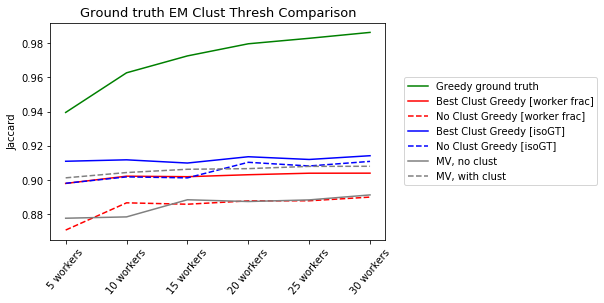

In [20]:
algoDict=[{"val":greedy_ground_truth,"name":'Greedy ground truth','color':"green",'linestyle':"-"},

    {"val":greedy_best_clust_worker_frac,"name":'Best Clust Greedy [worker frac]','color':"red",'linestyle':"-"},
    {"val":greedy_no_clust_worker_frac,"name":'No Clust Greedy [worker frac]','color':"red",'linestyle':"--"},

    {"val":greedy_best_clust_isoGT,"name":'Best Clust Greedy [isoGT]','color':"blue",'linestyle':"-"},
    {"val":greedy_no_clust_isoGT,"name":'No Clust Greedy [isoGT]','color':"blue",'linestyle':"--"},

    {"val":MV_noClust,"name":'MV, no clust','color':"gray",'linestyle':"-"},
    {"val":MV_withClust,"name":'MV, with clust','color':"gray",'linestyle':"--"}
]
metric_J = [metric for metric in metric_keys if 'J' in metric ]
#Nworker_performance = Nworker_performance.reindex(['5workers_rand0','10workers_rand0','15workers_rand0','20workers_rand0','25workers_rand0','30workers_rand0'])
for algo in algoDict:
    plt.plot(algo["val"],label=algo["name"],color=algo["color"],linestyle=algo["linestyle"])
plt.legend(bbox_to_anchor=(1.04,0.5),loc="center left")    
plt.ylabel("Jaccard")
plt.xticks(rotation=50)
a = gca().set_xticklabels([0,'5 workers','10 workers','15 workers','20 workers','25 workers','30 workers'])
plt.title("Ground truth EM Clust Thresh Comparison",fontsize=13)